# Scheduling Multipurpose Batch Processes using State-Task Networks in Python
[![batch_processessing.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/cookbook/batch_processessing.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/cookbook/batch_processessing.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/cookbook/batch_processessing.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/cookbook/batch_processessing.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/cookbook/batch_processessing.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/cookbook/batch_processessing.ipynb)](https://colab.ampl.com)

Description: The State-Task Network (STN) is an approach to modeling multipurpose batch process for the purpose of short term scheduling. It was first developed by Kondili, et al., in 1993, and subsequently developed and extended by others.

Tags: state-task networks, gdp, disjunctive programming, batch processes, batch processing

Notebook author: Jeffrey C. Kantor, Filipe Brandão <<fdabrandao@gmail.com>>

Based on: [Original notebook from the ND Pyomo Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/04.05-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.html)

In [1]:
# Install dependencies
%pip install -q amplpy pandas numpy matplotlib networkx

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs", "gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

SOLVER = "highs"

## References

Floudas, C. A., & Lin, X. (2005). Mixed integer linear programming in process scheduling: Modeling, algorithms, and applications. Annals of Operations Research, 139(1), 131-162.

Harjunkoski, I., Maravelias, C. T., Bongers, P., Castro, P. M., Engell, S., Grossmann, I. E., ... & Wassick, J. (2014). Scope for industrial applications of production scheduling models and solution methods. Computers & Chemical Engineering, 62, 161-193.

Kondili, E., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—I. MILP formulation. Computers & Chemical Engineering, 17(2), 211-227.

Méndez, C. A., Cerdá, J., Grossmann, I. E., Harjunkoski, I., & Fahl, M. (2006). State-of-the-art review of optimization methods for short-term scheduling of batch processes. Computers & Chemical Engineering, 30(6), 913-946.

Shah, N., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—II. Computational issues. Computers & Chemical Engineering, 17(2), 229-244.

Wassick, J. M., & Ferrio, J. (2011). Extending the resource task network for industrial applications. Computers & chemical engineering, 35(10), 2124-2140.

## Example (Kondili, et al., 1993)

A state-task network is a graphical representation of the activities in a multi-product batch process. The representation includes the minimum details needed for short term scheduling of batch operations.

A well-studied example due to Kondili (1993) is shown below. Other examples are available in the references cited above.

![Kondili_1993.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/Kondili_1993.png?raw=1)

Each circular node in the diagram designates material in a particular state.  The materials are generally held in suitable vessels with a known capacity. The relevant information for each state is the initial inventory, storage capacity, and the unit price of the material in each state. The price of materials in intermediate states may be assigned penalties in order to minimize the amount of work in progress.

The rectangular nodes denote process tasks. When scheduled for execution, each task is assigned an appropriate piece of equipment, and assigned a batch of material according to the incoming arcs. Each incoming arc begins at a state where the associated label indicates the mass fraction of the batch coming from that particular state. Outgoing arcs indicate the disposition of the batch to product states. The outgoing are labels indicate the fraction of the batch assigned to each product state, and the time necessary to produce that product.

Not shown in the diagram is the process equipment used to execute the tasks. A separate list of process units is available, each characterized by a capacity and list of tasks which can be performed in that unit.

### Exercise

Read this recipe for Hollandaise Sauce: http://www.foodnetwork.com/recipes/tyler-florence/hollandaise-sauce-recipe-1910043. Assume the available equipment consists of one sauce pan and a double-boiler on a stove. Draw a state-task network outlining the basic steps in the recipe.

## Encoding the STN data

The basic data structure specifies the states, tasks, and units comprising a state-task network. The intention is for all relevant problem data to be contained in a single JSON-like structure.

In [4]:
# planning horizon
H = 10

Kondili = {
    # time grid
    "TIME": range(0, H + 1),
    # states
    "STATES": {
        "Feed_A": {"capacity": 500, "initial": 500, "price": 0},
        "Feed_B": {"capacity": 500, "initial": 500, "price": 0},
        "Feed_C": {"capacity": 500, "initial": 500, "price": 0},
        "Hot_A": {"capacity": 100, "initial": 0, "price": -100},
        "Int_AB": {"capacity": 200, "initial": 0, "price": -100},
        "Int_BC": {"capacity": 150, "initial": 0, "price": -100},
        "Impure_E": {"capacity": 100, "initial": 0, "price": -100},
        "Product_1": {"capacity": 500, "initial": 0, "price": 10},
        "Product_2": {"capacity": 500, "initial": 0, "price": 10},
    },
    # state-to-task arcs indexed by (state, task)
    "ST_ARCS": {
        ("Feed_A", "Heating"): {"rho": 1.0},
        ("Feed_B", "Reaction_1"): {"rho": 0.5},
        ("Feed_C", "Reaction_1"): {"rho": 0.5},
        ("Feed_C", "Reaction_3"): {"rho": 0.2},
        ("Hot_A", "Reaction_2"): {"rho": 0.4},
        ("Int_AB", "Reaction_3"): {"rho": 0.8},
        ("Int_BC", "Reaction_2"): {"rho": 0.6},
        ("Impure_E", "Separation"): {"rho": 1.0},
    },
    # task-to-state arcs indexed by (task, state)
    "TS_ARCS": {
        ("Heating", "Hot_A"): {"dur": 1, "rho": 1.0},
        ("Reaction_2", "Product_1"): {"dur": 2, "rho": 0.4},
        ("Reaction_2", "Int_AB"): {"dur": 2, "rho": 0.6},
        ("Reaction_1", "Int_BC"): {"dur": 2, "rho": 1.0},
        ("Reaction_3", "Impure_E"): {"dur": 1, "rho": 1.0},
        ("Separation", "Int_AB"): {"dur": 2, "rho": 0.1},
        ("Separation", "Product_2"): {"dur": 1, "rho": 0.9},
    },
    # unit data indexed by (unit, task)
    "UNIT_TASKS": {
        ("Heater", "Heating"): {
            "Bmin": 0,
            "Bmax": 100,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_1", "Reaction_1"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_1", "Reaction_2"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_1", "Reaction_3"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_2", "Reaction_1"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_2", "Reaction_2"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_2", "Reaction_3"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Still", "Separation"): {
            "Bmin": 0,
            "Bmax": 200,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
    },
}

In [5]:
H = 16

Hydrolubes = {
    # time grid
    "TIME": range(0, H + 1),
    # states
    "STATES": {
        "Feed_A": {"capacity": 500, "initial": 500, "price": 0},
        "Feed_B": {"capacity": 500, "initial": 500, "price": 0},
        "Feed_C": {"capacity": 500, "initial": 500, "price": 0},
        "Hot_A": {"capacity": 100, "initial": 0, "price": -100},
        "Int_AB": {"capacity": 200, "initial": 0, "price": -100},
        "Int_BC": {"capacity": 150, "initial": 0, "price": -100},
        "Impure_E": {"capacity": 100, "initial": 0, "price": -100},
        "Product_1": {"capacity": 500, "initial": 0, "price": 10},
        "Product_2": {"capacity": 500, "initial": 0, "price": 10},
    },
    # state-to-task arcs indexed by (state, task)
    "ST_ARCS": {
        ("Feed_A", "Heating"): {"rho": 1.0},
        ("Feed_B", "Reaction_1"): {"rho": 0.5},
        ("Feed_C", "Reaction_1"): {"rho": 0.5},
        ("Feed_C", "Reaction_3"): {"rho": 0.2},
        ("Hot_A", "Reaction_2"): {"rho": 0.4},
        ("Int_AB", "Reaction_3"): {"rho": 0.8},
        ("Int_BC", "Reaction_2"): {"rho": 0.6},
        ("Impure_E", "Separation"): {"rho": 1.0},
    },
    # task-to-state arcs indexed by (task, state)
    "TS_ARCS": {
        ("Heating", "Hot_A"): {"dur": 1, "rho": 1.0},
        ("Reaction_2", "Product_1"): {"dur": 2, "rho": 0.4},
        ("Reaction_2", "Int_AB"): {"dur": 2, "rho": 0.6},
        ("Reaction_1", "Int_BC"): {"dur": 2, "rho": 1.0},
        ("Reaction_3", "Impure_E"): {"dur": 1, "rho": 1.0},
        ("Separation", "Int_AB"): {"dur": 2, "rho": 0.1},
        ("Separation", "Product_2"): {"dur": 1, "rho": 0.9},
    },
    # unit data indexed by (unit, task)
    "UNIT_TASKS": {
        ("Heater", "Heating"): {
            "Bmin": 0,
            "Bmax": 100,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_1", "Reaction_1"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_1", "Reaction_2"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_1", "Reaction_3"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_2", "Reaction_1"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_2", "Reaction_2"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Reactor_2", "Reaction_3"): {
            "Bmin": 0,
            "Bmax": 80,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
        ("Still", "Separation"): {
            "Bmin": 0,
            "Bmax": 200,
            "Cost": 1,
            "vCost": 0,
            "Tclean": 0,
        },
    },
}

In [6]:
import matplotlib.pyplot as plt
import networkx as nx


def remove_isolated_states(stn, verbose=False):
    states = set()
    for state in stn["STATES"]:
        states.add(state)

    tasks = set()
    connected_tasks = set()
    connected_states = set()
    for s, t in stn["ST_ARCS"]:
        tasks.add(t)
        if s not in states:
            continue
        connected_tasks.add(t)
        connected_states.add(s)
    for t, s in stn["TS_ARCS"]:
        tasks.add(t)
        if s not in states:
            continue
        connected_tasks.add(t)
        connected_states.add(s)
    units = set()
    connected_units = set()
    tasks_with_units = set()
    for u, t in stn["UNIT_TASKS"]:
        units.add(u)
        tasks_with_units.add(t)
        if t not in connected_tasks:
            continue
        connected_units.add(u)

    if verbose:
        print(f"isolated satates: {states-connected_states}")
        print(f"isolated tasks: {tasks-connected_tasks}")
        print(f"isolated units: {units-connected_units}")
        print(f"tasks without units: {tasks-tasks_with_units}")

    return (
        {
            # time grid
            "TIME": stn["TIME"],
            # states
            "STATES": {s: stn["STATES"][s] for s in connected_states},
            # state-to-task arcs indexed by (state, task)
            "ST_ARCS": {
                (s, t): stn["ST_ARCS"][(s, t)]
                for (s, t) in stn["ST_ARCS"]
                if s in connected_states and t in connected_tasks
            },
            # task-to-state arcs indexed by (task, state)
            "TS_ARCS": {
                (t, s): stn["TS_ARCS"][(t, s)]
                for (t, s) in stn["TS_ARCS"]
                if s in connected_states and t in connected_tasks
            },
            # unit data indexed by (unit, task)
            "UNIT_TASKS": {
                (u, t): stn["UNIT_TASKS"][(u, t)]
                for (u, t) in stn["UNIT_TASKS"]
                if t in connected_tasks
            },
        },
        connected_states,
        connected_tasks,
    )


def build_graph(stn, verbose=False):
    # Remove isolated nodes
    stn, connected_states, connected_tasks = remove_isolated_states(
        stn, verbose=verbose
    )
    # Create a directed graph
    graph = nx.DiGraph()

    # Add states and tasks as nodes
    graph.add_nodes_from(connected_states, type="state")
    graph.add_nodes_from(connected_tasks, type="task")

    # Add state-to-task and task-to-state arcs
    for (s, t), v in stn["ST_ARCS"].items():
        if s not in connected_states or t not in connected_tasks:
            continue
        graph.add_edge(s, t, rho=v["rho"])
    for (t, s), v in stn["TS_ARCS"].items():
        if s not in connected_states or t not in connected_tasks:
            continue
        graph.add_edge(t, s, rho=v["rho"])
    return stn, graph


def draw_graph(stn, graph, with_labels=False, verbose=False):
    # Determine initial and final states
    initial_states = {
        state
        for state, attr in stn["STATES"].items()
        if attr["initial"] > 0 and graph.in_degree(state) == 0
    }
    final_states = {state for state in stn["STATES"] if graph.out_degree(state) == 0}
    if verbose:
        print(f"initial states: {initial_states}")
        print(f"final states: {final_states}")

    tasks = set()
    for s, t in stn["ST_ARCS"]:
        tasks.add(t)
    for t, s in stn["TS_ARCS"]:
        tasks.add(t)

    # Position nodes
    initial_x = 0.1
    intermediate_x = 0.5
    final_x = 0.9
    y = 0.5
    new_pos = {}
    for node in graph.nodes():
        if node in initial_states:
            new_pos[node] = (initial_x, y)
            initial_x += 0.1
        elif node in final_states:
            new_pos[node] = (final_x, y)
            final_x -= 0.1
        else:
            new_pos[node] = (intermediate_x, y)
            intermediate_x += 0.1

    # Adjust positions of tasks based on their connected states
    task_y_offset = 0.2
    for node in tasks:
        avg_x = sum(
            new_pos[pred][0] for pred in graph.predecessors(node)
        ) / graph.in_degree(node)
        new_pos[node] = (avg_x, y - task_y_offset)

    # Draw the network graph
    plt.figure(figsize=(14, 8))
    node_colors = [
        (
            "yellow"
            if n in initial_states
            else (
                "red"
                if n in final_states
                else "skyblue" if graph.nodes[n]["type"] == "state" else "lightgreen"
            )
        )
        for n in graph.nodes()
    ]
    nx.draw(
        graph,
        new_pos,
        with_labels=with_labels,
        node_color=node_colors,
        node_size=100,
        font_size=9,
        font_weight="bold",
        arrowstyle="-|>",
        arrowsize=20,
    )
    edge_labels = nx.get_edge_attributes(graph, "rho")
    if with_labels:
        nx.draw_networkx_edge_labels(
            graph, new_pos, edge_labels=edge_labels, font_color="red"
        )
    plt.title("Network Graph with Spatially Separated Initial and Final States")
    plt.show()

In [7]:
initial_stn = Hydrolubes  # Hydrolubes, Kondili

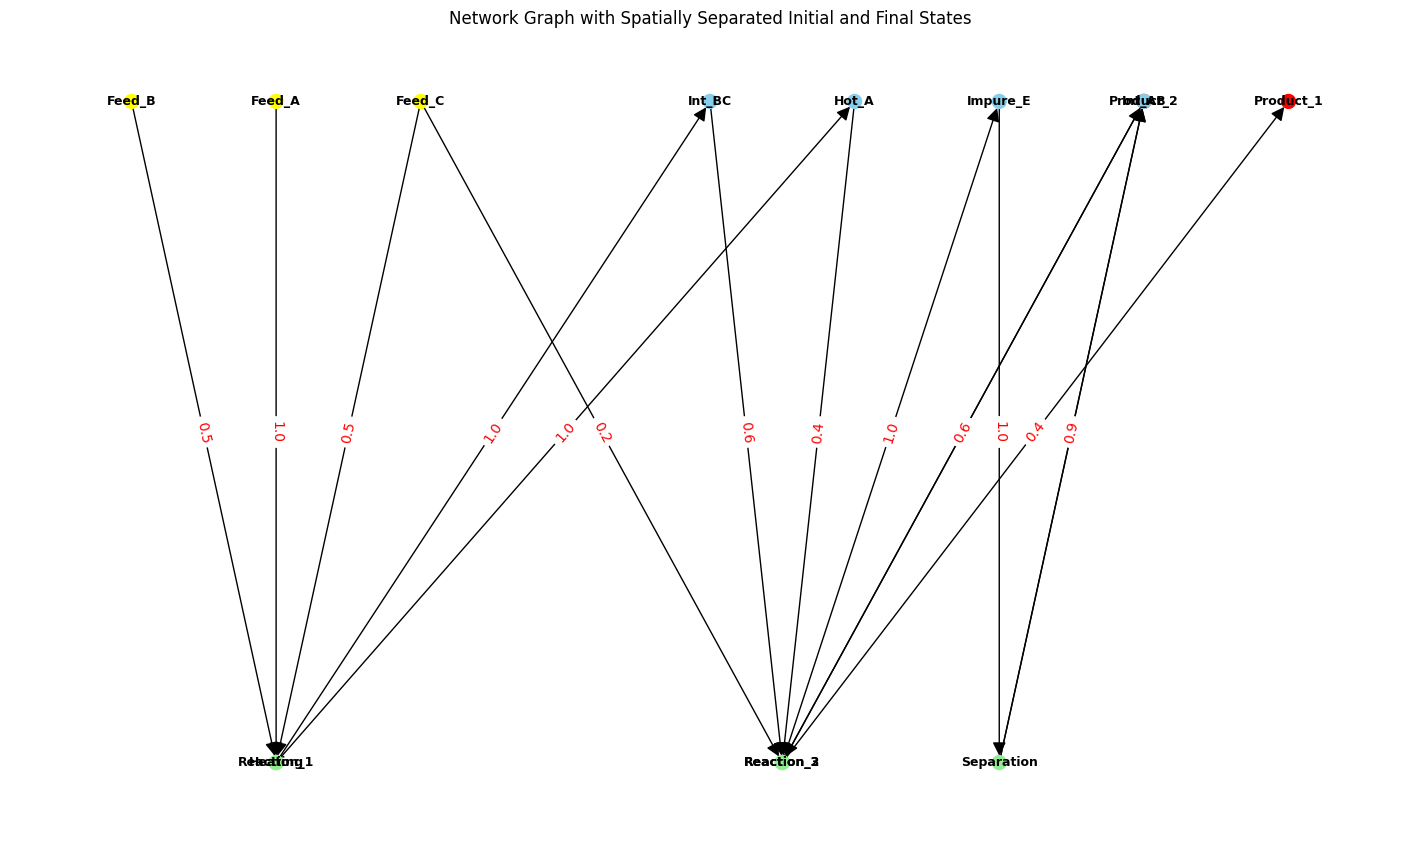

In [8]:
full_stn, full_graph = build_graph(initial_stn, verbose=False)
draw_graph(full_stn, full_graph, with_labels=True, verbose=False)

In [9]:
def list_predecessors(stn, graph, node, visited=set(), depth=0, verbose=False):
    visited.add(node)
    pred = list(graph.predecessors(node))
    if verbose:
        print(
            "  " * depth,
            node,
            graph.nodes[node]["type"],
            "->",
            [(p, graph.edges[p, node]["rho"]) for p in pred],
        )
    for p in pred:
        list_predecessors(stn, graph, p, visited, depth + 1, verbose)
    return visited


def clean_stn(stn, graph, target, verbose=False):
    visited = list_predecessors(stn, graph, target, verbose=verbose)
    return {
        # time grid
        "TIME": stn["TIME"],
        # states
        "STATES": {s: stn["STATES"][s] for s in stn["STATES"] if s in visited},
        # state-to-task arcs indexed by (state, task)
        "ST_ARCS": {
            (s, t): stn["ST_ARCS"][(s, t)]
            for (s, t) in stn["ST_ARCS"]
            if s in visited and t in visited
        },
        # task-to-state arcs indexed by (task, state)
        "TS_ARCS": {
            (t, s): stn["TS_ARCS"][(t, s)]
            for (t, s) in stn["TS_ARCS"]
            if s in visited and t in visited
        },
        # unit data indexed by (unit, task)
        "UNIT_TASKS": {
            (u, t): stn["UNIT_TASKS"][(u, t)]
            for (u, t) in stn["UNIT_TASKS"]
            if t in visited
        },
    }

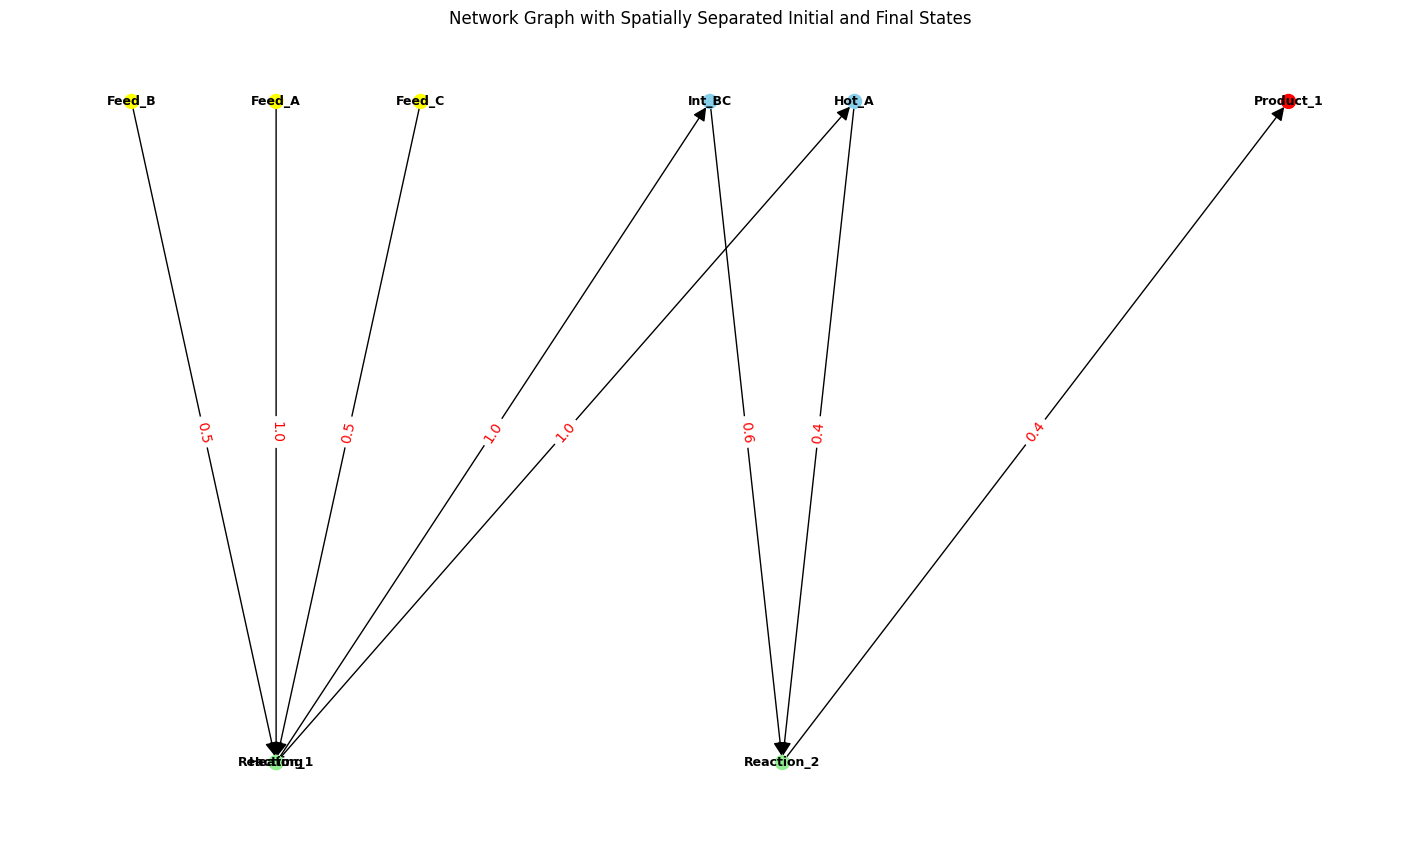

In [10]:
stn = clean_stn(full_stn, full_graph, "Product_1", verbose=False)
filtered_stn, filtered_graph = build_graph(stn)
draw_graph(filtered_stn, filtered_graph, with_labels=True)

In [11]:
STN = full_stn  # filtered_stn or full_stn

In [12]:
TIME = STN["TIME"]
unit_tasks_pd = pd.DataFrame.from_dict(STN["UNIT_TASKS"], orient="index")
states_df = pd.DataFrame.from_dict(STN["STATES"], orient="index")

### Setting a time grid

The following computations can be done on any time grid, including real-valued time points. TIME is a list of time points commencing at 0.

## Creating an AMPL model

The following AMPL model closely follows the development in Kondili, et al. (1993). In particular, the first step in the model is to process the STN data to create sets as given in Kondili.  

One important difference from Kondili is the adoption of a more natural time scale that starts at $t = 0$ and extends to $t = H$ (rather than from 1 to H+1).

A second difference is the introduction of an additional decision variable denoted by $Q_{j,t}$ indicating the amount of material in unit $j$ at time $t$. A material balance then reads

$$
\begin{align*}
Q_{jt} & = Q_{j(t-1)} + \sum_{i\in I_j}B_{ijt} - \sum_{i\in I_j}\sum_{\substack{s \in \bar{S}_i\\s\ni t-P_{is} \geq 0}}\bar{\rho}_{is}B_{ij(t-P_{is})} \qquad \forall j,t
\end{align*}
$$

Following Kondili's notation, $I_j$ is the set of tasks that can be performed in unit $j$, and $\bar{S}_i$ is the set of states fed by task $j$. We assume the units are empty at the beginning and end of production period, i.e.,

$$
\begin{align*}
Q_{j(-1)} & = 0 \qquad \forall j \\
Q_{j,H} & = 0 \qquad \forall j
\end{align*}
$$

The unit allocation constraints are written the full backward aggregation method described by Shah (1993).  The allocation constraint reads

$$
\begin{align*}
\sum_{i \in I_j} \sum_{t'=t}^{t-p_i+1} W_{ijt'} & \leq 1 \qquad \forall j,t
\end{align*}
$$

Each processing unit $j$ is tagged with a minimum and maximum capacity, $B_{ij}^{min}$ and $B_{ij}^{max}$, respectively, denoting the minimum and maximum batch sizes for each task $i$. A minimum capacity may be needed to cover heat exchange coils in a reactor or mixing blades in a blender, for example. The capacity may depend on the nature of the task being performed.  These constraints are written

$$
\begin{align*}
B_{ij}^{min}W_{ijt} & \leq B_{ijt} \leq  B_{ij}^{max}W_{ijt} \qquad \forall j, \forall i\in I_j, \forall t
\end{align*}
$$

### Characterization of tasks

In [13]:
STATES = STN["STATES"]
ST_ARCS = STN["ST_ARCS"]
TS_ARCS = STN["TS_ARCS"]
UNIT_TASKS = STN["UNIT_TASKS"]
TIME = STN["TIME"]
H = max(TIME)

In [14]:
# set of tasks
TASKS = set([i for (j, i) in UNIT_TASKS])

# S[i] input set of states which feed task i
S = {i: set() for i in TASKS}
for s, i in ST_ARCS:
    S[i].add(s)

# S_[i] output set of states fed by task i
S_ = {i: set() for i in TASKS}
for i, s in TS_ARCS:
    S_[i].add(s)

# rho[(i,s)] input fraction of task i from state s
rho = {(i, s): ST_ARCS[(s, i)]["rho"] for (s, i) in ST_ARCS}

# rho_[(i,s)] output fraction of task i to state s
rho_ = {(i, s): TS_ARCS[(i, s)]["rho"] for (i, s) in TS_ARCS}

# P[(i,s)] time for task i output to state s
P = {(i, s): TS_ARCS[(i, s)]["dur"] for (i, s) in TS_ARCS}

# p[i] completion time for task i
p = {i: max([P[(i, s)] for s in S_[i]]) for i in TASKS}

# K[i] set of units capable of task i
K = {i: set() for i in TASKS}
for j, i in UNIT_TASKS:
    K[i].add(j)

### Characterization of states

In [15]:
# T[s] set of tasks receiving material from state s
T = {s: set() for s in STATES}
for s, i in ST_ARCS:
    T[s].add(i)

# set of tasks producing material for state s
T_ = {s: set() for s in STATES}
for i, s in TS_ARCS:
    T_[s].add(i)

# C[s] storage capacity for state s
C = {s: STATES[s]["capacity"] for s in STATES}

### Characterization of units

In [16]:
UNITS = list(sorted(set([j for (j, i) in UNIT_TASKS])))

# I[j] set of tasks performed with unit j
I = {j: set() for j in UNITS}
for j, i in UNIT_TASKS:
    I[j].add(i)

# Bmax[(i,j)] maximum capacity of unit j for task i
Bmax = {(i, j): UNIT_TASKS[(j, i)]["Bmax"] for (j, i) in UNIT_TASKS}

# Bmin[(i,j)] minimum capacity of unit j for task i
Bmin = {(i, j): UNIT_TASKS[(j, i)]["Bmin"] for (j, i) in UNIT_TASKS}

### AMPL model

In [17]:
%%writefile batch_process.mod
set TASKS;
set UNITS;
set TIME;
param H;  # End time or horizon

set STATES;
param price{STATES};
param initial{STATES};

set I{j in UNITS};  # I[j] set of tasks performed with unit j
set K{i in TASKS};  # K[i] set of units capable of task i

set S_In{i in TASKS};  # S_In[i] input set of states which feed task i
set S_Out{i in TASKS};  # S_Out[i] output set of states fed by task i
set T_In{s in STATES};  # T_In[s] set of tasks producing material for state s
set T_Out{s in STATES};  # T_Out[s] set of tasks receiving material from state s

param P{i in TASKS, s in S_Out[i]};  # P[i,s] time for task i output to state s
param p{i in TASKS};  # Processing times for tasks
param Tclean{(j,i) in UNITS cross TASKS};

param C{s in STATES};  # Capacity constraints for states

param rho_in{i in TASKS, s in S_In[i]};  # rho_in[i,s] input fraction of task i from state s
param rho_out{i in TASKS, s in S_Out[i]};  # rho_out[i,s] output fraction of task i to state s

param Bmin{(i,j) in UNITS cross TASKS};
param Bmax{(i,j) in UNITS cross TASKS};
param Cost{(i,j) in UNITS cross TASKS} > 0;
param vCost{(i,j) in UNITS cross TASKS} > 0;

# W[i,j,t] 1 if task i starts in unit j at time t
var W{i in TASKS, j in K[i], t in TIME} binary;

# B[i,j,t] size of batch assigned to task i in unit j at time t
var B{i in TASKS, j in K[i], t in TIME} >= 0;

# S[s,t] inventory of state s at time t
var S{s in STATES, t in TIME} >= 0, <= C[s];

# Q[j,t] inventory of unit j at time t
var Q{j in UNITS, t in TIME} >= 0;

# Objective function
var TotalValue = sum{s in STATES} price[s] * S[s,H];
var TotalCost = sum{i in TASKS, j in K[i], t in TIME} (Cost[j,i] * W[i,j,t] + vCost[j,i] * B[i,j,t]);;

# Objective function
maximize Total_Profit: TotalValue - TotalCost;

# Constraints

# a unit can only be allocated to one task
subject to Unit_Allocation{j in UNITS, t in TIME}:
    sum{i in I[j], tprime in TIME: tprime >= (t - p[i] + 1 - Tclean[j,i]) && tprime <= t} W[i,j,tprime] <= 1;

# state mass balances
subject to State_Balance{s in STATES, t in TIME}:
    S[s,t] = (if t > 0 then S[s,t-1] else initial[s])
           + sum {i in T_In[s], j in K[i]: t >= P[i,s]} rho_out[i,s]*B[i,j,t-P[i,s]]
           - sum {i in T_Out[s], j in K[i]} rho_in[i,s] * B[i,j,t];

# unit capacity constraints
subject to Unit_Capacity_Min{i in TASKS, j in K[i], t in TIME}:
  W[i,j,t]*Bmin[j,i] <= B[i,j,t];

subject to Unit_Capacity_Max{i in TASKS, j in K[i], t in TIME}:
  B[i,j,t] <= W[i,j,t]*Bmax[j,i];

# unit mass balances
subject to Unit_Balance{j in UNITS, t in TIME}:
    Q[j,t] = (if t > 0 then Q[j,t-1] else 0)
           + sum {i in I[j]} B[i,j,t]
           - sum {i in I[j], s in S_Out[i]: t >= P[i,s]} rho_out[i,s] * B[i,j,t-P[i,s]];

# unit terminal condition
subject to Terminal_Condition{j in UNITS}:
    Q[j,H] = 0;

Writing batch_process.mod


In [18]:
ampl = AMPL()
ampl.read("batch_process.mod")
TIME = np.array(TIME)
ampl.set["TIME"] = TIME
ampl.set["TASKS"] = TASKS
ampl.set["UNITS"] = UNITS
ampl.set["STATES"] = STATES.keys()
ampl.set["I"] = I
ampl.set["K"] = K
ampl.set["T_In"] = T_
ampl.set["T_Out"] = T
ampl.set["S_In"] = S
ampl.set["S_Out"] = S_
ampl.param["H"] = H
ampl.param["price"] = states_df[["price"]]
ampl.param["initial"] = states_df[["initial"]]
ampl.param["P"] = P
ampl.param["p"] = p
ampl.param["C"] = states_df[["capacity"]]
ampl.param["rho_in"] = rho
ampl.param["rho_out"] = rho_
ampl.param["Bmin"] = unit_tasks_pd[["Bmin"]]
ampl.param["Bmax"] = unit_tasks_pd[["Bmax"]]
ampl.param["Cost"] = unit_tasks_pd[["Cost"]]
ampl.param["vCost"] = unit_tasks_pd[["vCost"]]
ampl.param["Tclean"] = unit_tasks_pd[["Tclean"]]

In [19]:
# ampl.option["presolve_logfile"] = "presolve.log"
# ampl.option["presolve"] = 0
if SOLVER == "highs":
    ampl.solve(solver="highs", highs_options="outlev=1")
elif SOLVER == "gurobi":
    ampl.solve(solver="gurobi", gurobi_options="outlev=1 iis=1 timelim=600")
elif SOLVER == "cplex":
    ampl.solve(
        solver="cplexmp",
        highs_options="outlev=1",
        cplex_options="outlev=1 iis=1 timelim=30",
    )
assert ampl.solve_result in ["solved", "limit", "infeasible"]

HiGHS 1.7.0:   tech:outlev = 1
Running HiGHS 1.7.0 (git hash: 50670fd): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 2e+02]
  Cost   [1e+00, 1e+02]
  Bound  [1e+00, 5e+02]
  RHS    [1e+00, 5e+02]
Presolving model
341 rows, 413 cols, 1316 nonzeros  0s
268 rows, 340 cols, 1151 nonzeros  0s
220 rows, 293 cols, 881 nonzeros  0s
194 rows, 255 cols, 757 nonzeros  0s

Solving MIP model with:
   194 rows
   255 cols (100 binary, 0 integer, 0 implied int., 155 continuous)
   757 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   10000           -inf                 inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   4923.399757     3303.666667       49.03%        0      0      0     

In [20]:
# %load_ext google.colab.data_table
if ampl.solve_result == "infeasible":
    var_iis, con_iis = ampl.get_iis()
    print("var_iis:", var_iis)
    print("con_iis:", con_iis)
else:
    solution = ampl.get_solution()
    print("solution:", solution)

solution: {"W['Reaction_1','Reactor_2',0]": 1, "W['Reaction_1','Reactor_2',4]": -4.973799150320706e-15, "W['Reaction_1','Reactor_2',5]": 1, "W['Reaction_1','Reactor_2',9]": 9.947598300641404e-16, "W['Reaction_1','Reactor_1',0]": 1, "W['Reaction_1','Reactor_1',4]": -2.615241356807019e-14, "W['Reaction_1','Reactor_1',5]": 8.688161301506626e-14, "W['Reaction_1','Reactor_1',6]": 0.9999999999998922, "W['Reaction_1','Reactor_1',9]": 1.978625596699146e-14, "W['Separation','Still',5]": 6.389999640532549e-14, "W['Separation','Still',8]": 1, "W['Separation','Still',11]": 1, "W['Separation','Still',14]": 1, "W['Reaction_3','Reactor_2',4]": 0.9999999999999983, "W['Reaction_3','Reactor_2',7]": 1, "W['Reaction_3','Reactor_2',10]": 1, "W['Reaction_3','Reactor_2',13]": 1, "W['Reaction_3','Reactor_1',4]": 8.688161301506626e-14, "W['Reaction_3','Reactor_1',7]": 8.693046282814976e-14, "W['Reaction_3','Reactor_1',8]": 1.978625596699146e-14, "W['Reaction_3','Reactor_1',10]": 0.9999999999999803, "W['Reactio

In [21]:
assert ampl.solve_result in ["solved", "limit"]

## Analysis

### Profitability



In [22]:
total_value, total_cost = ampl.get_value("TotalValue"), ampl.get_value("TotalCost")
print("Value of State Inventories = {0:12.2f}".format(total_value))
print("  Cost of Unit Assignments = {0:12.2f}".format(total_cost))
print("             Net Objective = {0:12.2f}".format(total_value - total_cost))

Value of State Inventories =      4893.33
  Cost of Unit Assignments =        23.00
             Net Objective =      4870.33


### Unit assignment

In [23]:
solution = ampl.get_solution(flat=False, zeros=True)
# solution = {
#    "W": ampl.var["W"].to_dict(),
#    "B": ampl.var["B"].to_dict(),
#    "S": ampl.var["S"].to_dict(),
#    "Q": ampl.var["Q"].to_dict(),
# }

In [24]:
UnitAssignment = pd.DataFrame({j: [None for t in TIME] for j in UNITS}, index=TIME)

for t in TIME:
    for j in UNITS:
        for i in I[j]:
            for s in S_[i]:
                if t - p[i] >= 0:
                    if solution["W"][i, j, max(TIME[TIME <= t - p[i]])] > 0:
                        UnitAssignment.loc[t, j] = None
        for i in I[j]:
            if solution["W"][i, j, t] > 0:
                UnitAssignment.loc[t, j] = (i, solution["B"][i, j, t])

UnitAssignment

,Heater,Reactor_1,Reactor_2,Still
0,None,"(Reaction_1, 80)","(Reaction_1, 80)",None
1,"(Heating, 95.99999999999866)",None,None,None
2,None,"(Reaction_2, 80)","(Reaction_2, 80)",None
3,None,None,None,None
4,None,"(Reaction_2, 79.99999999999514)","(Reaction_2, 5.275779813018744e-13)",None
5,"(Heating, 17.33333333332865)","(Reaction_1, 6.9505290412053e-12)","(Reaction_1, 80)","(Separation, 5.115907697472721e-12)"
6,None,"(Reaction_2, 1.667406953250368e-12)",None,None
7,"(Heating, 99.99999999999993)","(Reaction_3, 6.954437026251981e-12)","(Reaction_3, 80)",None
8,None,"(Reaction_2, 79.99999999999842)","(Reaction_2, 79.99999999999991)","(Separation, 160.0000000000086)"
9,None,"(Reaction_1, 1.588229547877518e-12)","(Reaction_1, 7.958078640513123e-14)",None


### State inventories

In [25]:
pd.DataFrame(
    [[solution["S"][s, t] for s in STATES.keys()] for t in TIME],
    columns=STATES.keys(),
    index=TIME,
)

,Feed_B,Int_BC,Hot_A,Impure_E,Product_1,Product_2,Feed_A,Int_AB,Feed_C
0,420.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,500.000000,0.0,420.0
1,420.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,404.000000,0.0,420.0
2,420.0,64.0,3.200000e+01,0.000000e+00,0.000000,0.000000e+00,404.000000,0.0,420.0
3,420.0,64.0,3.200000e+01,0.000000e+00,0.000000,0.000000e+00,404.000000,0.0,420.0
4,420.0,16.0,3.929301e-13,0.000000e+00,64.000000,0.000000e+00,404.000000,32.0,404.0
5,380.0,16.0,0.000000e+00,8.000000e+01,64.000000,0.000000e+00,386.666667,32.0,364.0
6,340.0,16.0,1.733333e+01,8.000000e+01,96.000000,4.604317e-12,386.666667,80.0,324.0
7,340.0,96.0,1.733333e+01,8.000000e+01,96.000000,4.604317e-12,286.666667,16.0,308.0
8,340.0,80.0,5.333333e+01,0.000000e+00,96.000000,4.604317e-12,286.666667,16.0,308.0
9,340.0,80.0,5.333333e+01,1.582900e-12,96.000000,1.440000e+02,286.666667,16.0,308.0


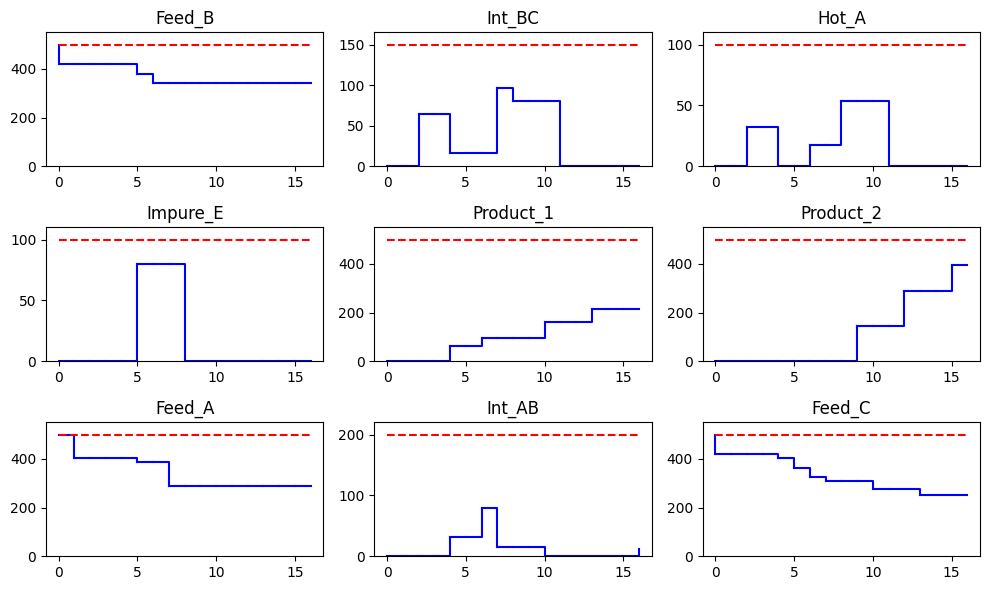

In [26]:
from math import ceil

plt.figure(figsize=(10, 6))
for s, idx in zip(STATES.keys(), range(0, len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys()) / 3), 3, idx + 1)
    tlast, ylast = 0, STATES[s]["initial"]
    for t, y in zip(list(TIME), [solution["S"][s, t] for t in TIME]):
        plt.plot([tlast, t, t], [ylast, ylast, y], "b")
        # plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast, ylast = t, y
    plt.ylim(0, 1.1 * C[s])
    plt.plot([0, H], [C[s], C[s]], "r--")
    plt.title(s)
plt.tight_layout()

### Unit batch inventories

In [27]:
pd.DataFrame(
    [[solution["Q"][j, t] for j in UNITS] for t in TIME], columns=UNITS, index=TIME
)

,Heater,Reactor_1,Reactor_2,Still
0,0.000000e+00,80.0,80.000000,0.000000e+00
1,9.600000e+01,80.0,80.000000,0.000000e+00
2,0.000000e+00,80.0,80.000000,0.000000e+00
3,0.000000e+00,80.0,80.000000,0.000000e+00
4,0.000000e+00,80.0,80.000000,0.000000e+00
5,1.733333e+01,80.0,80.000000,5.115908e-12
6,-2.886580e-14,80.0,80.000000,5.115908e-13
7,1.000000e+02,80.0,80.000000,0.000000e+00
8,0.000000e+00,80.0,80.000000,1.600000e+02
9,0.000000e+00,80.0,80.000000,1.600000e+01


### Gannt chart

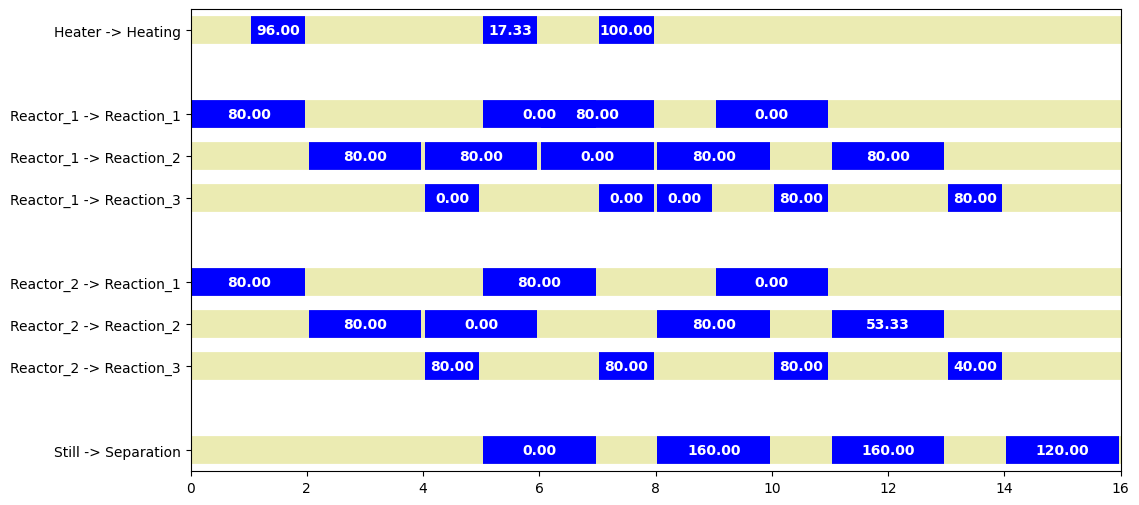

In [28]:
plt.figure(figsize=(12, 6))

gap = H / 500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j, i))
        plt.plot([0, H], [idx, idx], lw=20, alpha=0.3, color="y")
        for t in TIME:
            if solution["W"][i, j, t] > 0:
                plt.plot(
                    [t + gap, t + p[i] - gap],
                    [idx, idx],
                    "b",
                    lw=20,
                    solid_capstyle="butt",
                )
                txt = "{0:.2f}".format(solution["B"][i, j, t])
                plt.text(
                    t + p[i] / 2,
                    idx,
                    txt,
                    color="white",
                    weight="bold",
                    ha="center",
                    va="center",
                )
plt.xlim(0, H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls)

## Trace of events and states

In [29]:
sep = "\n--------------------------------------------------------------------------------------------\n"
print(sep)
print("Starting Conditions")
print("    Initial Inventories:")
for s in STATES.keys():
    print("        {0:10s}  {1:6.1f} kg".format(s, STATES[s]["initial"]))

units = {j: {"assignment": "None", "t": 0} for j in UNITS}

for t in TIME:
    print(sep)
    print("Time =", t, "hr")
    print("    Instructions:")
    for j in UNITS:
        units[j]["t"] += 1
        # transfer from unit to states
        for i in I[j]:
            for s in S_[i]:
                if t - P[(i, s)] >= 0:
                    amt = (
                        rho_[(i, s)]
                        * solution["B"][i, j, max(TIME[TIME <= t - P[(i, s)]])]
                    )
                    if amt > 0:
                        print("        Transfer", amt, "kg from", j, "to", s)
    for j in UNITS:
        # release units from tasks
        for i in I[j]:
            if t - p[i] >= 0:
                if solution["W"][i, j, max(TIME[TIME <= t - p[i]])] > 0:
                    print("        Release", j, "from", i)
                    units[j]["assignment"] = "None"
                    units[j]["t"] = 0
        # assign units to tasks
        for i in I[j]:
            if solution["W"][i, j, t] > 0:
                print(
                    "        Assign",
                    j,
                    "with capacity",
                    Bmax[(i, j)],
                    "kg to task",
                    i,
                    "for",
                    p[i],
                    "hours",
                )
                units[j]["assignment"] = i
                units[j]["t"] = 1
        # transfer from states to starting tasks
        for i in I[j]:
            for s in S[i]:
                amt = rho[(i, s)] * solution["B"][i, j, t]
                if amt > 0:
                    print("        Transfer", amt, "kg from", s, "to", j)
    print("\n    Inventories are now:")
    for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s, solution["S"][s, t]))
    print("\n    Unit Assignments are now:")
    for j in UNITS:
        if units[j]["assignment"] != "None":
            fmt = "        {0:s} performs the {1:s} task with a {2:.2f} kg batch for hour {3:f} of {4:f}"
            i = units[j]["assignment"]
            print(fmt.format(j, i, solution["Q"][j, t], units[j]["t"], p[i]))

print(sep)
print("Final Conditions")
print("    Final Inventories:")
for s in STATES.keys():
    print("        {0:10s}  {1:6.1f} kg".format(s, solution["S"][s, H]))


--------------------------------------------------------------------------------------------

Starting Conditions
    Initial Inventories:
        Feed_B       500.0 kg
        Int_BC         0.0 kg
        Hot_A          0.0 kg
        Impure_E       0.0 kg
        Product_1      0.0 kg
        Product_2      0.0 kg
        Feed_A       500.0 kg
        Int_AB         0.0 kg
        Feed_C       500.0 kg

--------------------------------------------------------------------------------------------

Time = 0 hr
    Instructions:
        Assign Reactor_1 with capacity 80 kg to task Reaction_1 for 2 hours
        Transfer 40.0 kg from Feed_B to Reactor_1
        Transfer 40.0 kg from Feed_C to Reactor_1
        Assign Reactor_2 with capacity 80 kg to task Reaction_1 for 2 hours
        Transfer 40.0 kg from Feed_B to Reactor_2
        Transfer 40.0 kg from Feed_C to Reactor_2

    Inventories are now:
        Feed_B       420.0 kg
        Int_BC         0.0 kg
        Hot_A          0.0 